# Implement Online portfolio algorithms directly into the Gym environment

In [150]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000


TEST_START_DATE = '2022-03-15'
TEST_END_DATE = '2023-12-30'


# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

print(processed_test)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (2712, 8)
            date        open        high         low       close    volume  \
0     2022-03-15  150.899994  155.570007  150.380005  152.784851  92964300   
1     2022-03-15  176.300003  180.500000  175.600006  179.889999   8051500   
2     2022-03-15   44.500000   44.900002   44.070000   41.876358  34448900   
3     2022-03-15  280.350006  287.820007  278.730011  280.469757  34245100   
4     2022-03-15  202.089996  206.410004  201.399994  201.768463   8277700   
...          ...         ...         ...         ...         ...       ...   
2707  2023-12-29  260.670013  262.220001  259.559998  260.660004   3681900   
2708  2023-12-29   50.299999   50.570000   49.770000   49.585903  29266500   
2709  2023-12-29  376.000000  377.160004  373.480011  373.248932  18723000   
2710  2023-12-29  260.570007  261.459991  259.670013  258.375092   4074600   
2711  2023-12-29   52.509998   52.693333   52.386665   52.042637  21948300   

       tic  day  
0     AAPL    

In [151]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize


import scipy.optimize as optimize
# Found this here:  
# https://github.com/Marigold/universal-portfolios/blob/master/universal/tools.py
def optimize_log_returns(
    prices
):
    print("Opt pricing")
    print(prices)

    assert prices.notnull().all().all()

    x_0 = np.ones(prices.shape[1]) / float(prices.shape[1])

    # Using price returns here.
    objective = lambda b: -np.sum(np.log(np.maximum(np.dot(prices - 1, b) + 1, 0.0001)))

    # We do not allow this portfolio to hold cash
    cons = ({"type": "eq", "fun": lambda b: 1 - sum(b)},)

    # problem optimization
    res = optimize.minimize(
        objective,
        x_0,
        bounds=[(0.0, 1.0)] * len(x_0),
        constraints=cons,
        method="slsqp"
    )

    if res.success:
        return res.x
    raise ValueError("Could not find an optimal value when optimizing over prices.")

In [152]:
import numpy as np
import pandas as pd

from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback
from typing import Any, ClassVar, Dict, Iterable, List, Optional, Tuple, Type, TypeVar, Union

# TODO add refrences to the code: http://www-isl.stanford.edu/~cover/papers/paper93.pdf


class BCRPModel:
    def __init__(
            self, 
            env: Union[GymEnv, str],
            policy: Any, # Policy doesnt matter here
            device: str, # device doesnt matter here
            policy_kwargs: Optional[Dict[str, Any]] = None, # policy_kwargs doesnt matter here
            ) -> None:
        
        # Super simple algorithm, we only need the environment

        assert env is not None 
        self.env = env

        # This portoflio cheats by pulling the full price range ange getting the best portfolio weights in hindsight
        self._full_hindsight_prices = self.env._df

        # Pull out the actions space dimensions for the portfolio
        self.action_space_shape = self.env.action_space.shape
        self.portfolio_length = self.action_space_shape[0]

        # Calculate the inital weights, for BCRP we use hinesight to get the best possible weights over the time range
        # Here we will cheat and calculate what the best weights would have been
        # This is obviously a benchmark metric and does not work in reality (because we can't see into the future)
        
        # Pivot the DataFrame 
        pivoted_df = self._full_hindsight_prices.pivot(index='date', columns='tic', values='close') 

        # Calculate the price ratios
        price_ratios = pivoted_df.pct_change() + 1
        price_ratios.dropna(inplace=True)
        
        # Get the magic weights
        self.target_weights = np.array(optimize_log_returns(price_ratios))
        # Assume no cash
        self.target_weights = np.insert(self.target_weights, 0, 0)

    def train(self) -> None:
        # This model is derministic and doesnt learn anything, it only predicts
        raise NotImplementedError("Can't use 'train' on a benchmark model, use predict instead. These models are deterministic.")

    def learn(
        self
    ):
        # This model is derministic and doesnt learn anything, it only predicts
        raise NotImplementedError("Can't use 'learn' on a benchmark model, use predict instead. These models are deterministic.")

    def predict(
        self,
        observation: Union[np.ndarray, Dict[str, np.ndarray]],
        state: Optional[Tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False, # This is always determininistic
    ) -> Tuple[np.ndarray, Optional[Tuple[np.ndarray, ...]]]:

        # This comes from the policies class in stable baselines.
        # Use this to validate the environment.
        if isinstance(observation, tuple) and len(observation) == 2 and isinstance(observation[1], dict):
            raise ValueError(
                "You have passed a tuple to the predict() function instead of a Numpy array or a Dict. "
                "You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) "
                "vs `obs = vec_env.reset()` (SB3 VecEnv). "
                "See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 "
                "and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api"
            )
        
        # We always just return the target BCRP weights
        actions = self.target_weights.reshape(1, self.portfolio_length)

        # The state doesnt matter here
        return actions, None

In [153]:


MODELS = {"bcrp": BCRPModel}

class DRLStableAgent:
    """Implementation for DRL algorithms for portfolio optimization.

    Note:
        During testing, the agent is optimized through online learning.
        The parameters of the policy is updated repeatedly after a constant
        period of time. To disable it, set learning rate to 0.

    Attributes:
        env: Gym environment class.
    """

    def __init__(self, env):
        """Agent initialization.

        Args:
            env: Gym environment to be used in training.
        """
        self.env = env

    def get_model(
        self, model_name, device="cpu", model_kwargs=None, policy_kwargs=None
    ):
        """Setups DRL model.

        Args:
            model_name: Name of the model according to MODELS list.
            device: Device used to instantiate neural networks.
            model_kwargs: Arguments to be passed to model class.
            policy_kwargs: Arguments to be passed to policy class.

        Note:
            model_kwargs and policy_kwargs are dictionaries. The keys must be strings
            with the same names as the class arguments. Example for model_kwargs::

            { "lr": 0.01, "policy": EIIE }

        Returns:
            An instance of the model.
        """
        if model_name not in MODELS:
            raise NotImplementedError("The model requested was not implemented.")

        model = MODELS[model_name]
        model_kwargs = {} if model_kwargs is None else model_kwargs
        policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        # add device settings
        model_kwargs["device"] = device
        #policy_kwargs["device"] = device

        # add policy_kwargs inside model_kwargs
        model_kwargs["policy_kwargs"] = policy_kwargs

        # TODO default to usethe MlpPolicy
        return model(env=self.env, policy="MlpPolicy", **model_kwargs)

    @staticmethod
    def train_model(model, env, episodes=1):
        """Trains portfolio optimization model.

        Args:
            model: Instance of the model.
            episoded: Number of episodes.

        Returns:
            An instance of the trained model.
        """
        max_steps = len(env._df['date'].unique())

        print("Max number of time steps in an episode: ", max_steps)

        model.learn(
            total_timesteps = max_steps * episodes # TODO fix this
        )
        return model

    @staticmethod
    def DRL_prediction(model, env, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = env.get_sb_env()
        
        

        test_env.reset()
        max_steps = len(env._df['date'].unique())

        validation_assets = None
        validation_dates = None

        for i in range(max_steps):
            action, _states = model.predict(test_obs, deterministic=deterministic)

            # Pull out the latest assets and dates
            validation_assets = env._asset_memory["final"]
            validation_dates = env._date_memory

            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)

            if dones[0]:
                print("hit end!")
                break
        
        return validation_assets, validation_dates

In [154]:

from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df

print(portfolio_norm_df)

print(processed_test)

# portfolio_norm_df = processed_test



environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

environment = PortfolioOptimizationEnv(
        portfolio_norm_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )

BCRP_results = {
    "date": {},
    "training": {},
    "2021": {},
    "2022": {},
    "2023": {}
}


# Training
agent_bcrp = DRLStableAgent(env = environment)
model_bcrp = agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment)
BCRP_results["training"] = environment._terminal_asset_memory["final"]
BCRP_results["date"] = environment._terminal_date_memory


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.50910888 0.56023592 0.41409952 0.6763984  0.52470072 0.44650113
 0.53702971 0.49359481 0.44110251 0.49491188 0.55086691 0.50729565
 0.56433829 0.43127293 0.41877088 0.40197698 0.48772084 0.42493894
 0.4193574  0.3956512  0.43408725 0.38673673 0.41253327 0.37800188
 0.37088203 0.37201016 0.47769356 0.46484923 0.52598767 0.52367006
 0.48226854 0.71311815 0.72150141 0.67389897 0.48721536 0.59285495
 0.71480761 0.63594375 0.72057206 0.63179319 0.78142518 1.
 0.62425877 0.47449535 0.42900023 0.60099506 0.74531276 0.7525991
 0.64471528 0.57027141 0.50647145 0.49616926 0.49823386 0.56800254
 0.40682249 0.3962065  0.48504562 0.39210085 0.37134424 0.2954524
 0.38046133 0.50074972 0.6692539  0.464312   0.50127052 0.59212878
 0.7366858  0.44359043 0.4020175  0.39

            date      open      high       low     close    volume   tic   day
0     2022-03-15  0.762044  0.779331  0.763350  0.774990  0.509109  AAPL  0.25
1     2022-03-15  0.662907  0.674665  0.673055  0.680705  0.199434    BA  0.25
2     2022-03-15  0.851675  0.855075  0.859399  0.836036  0.231904  INTC  0.25
3     2022-03-15  0.730535  0.748946  0.737069  0.738351  0.397727  MSFT  0.25
4     2022-03-15  0.767848  0.784084  0.775600  0.774871  0.404568     V  0.25
...          ...       ...       ...       ...       ...       ...   ...   ...
2707  2023-12-29  0.980147  0.980115  0.994864  0.986340  0.091200    BA  1.00
2708  2023-12-29  0.962679  0.963055  0.970554  0.989953  0.197017  INTC  1.00
2709  2023-12-29  0.979779  0.981421  0.987624  0.982597  0.217451  MSFT  1.00
2710  2023-12-29  0.990045  0.993200  1.000000  0.992263  0.199144     V  1.00
2711  2023-12-29  0.935562  0.930211  0.938213  0.932003  0.165099   WMT  1.00

[2712 rows x 8 columns]
            date        ope

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1451033.75
Final accumulative portfolio value: 1.45103375
Maximum DrawDown: -0.37694995442360546
Sharpe ratio: 0.7853703652730561
Total commission cost: 2168.9519776907982
hit end!


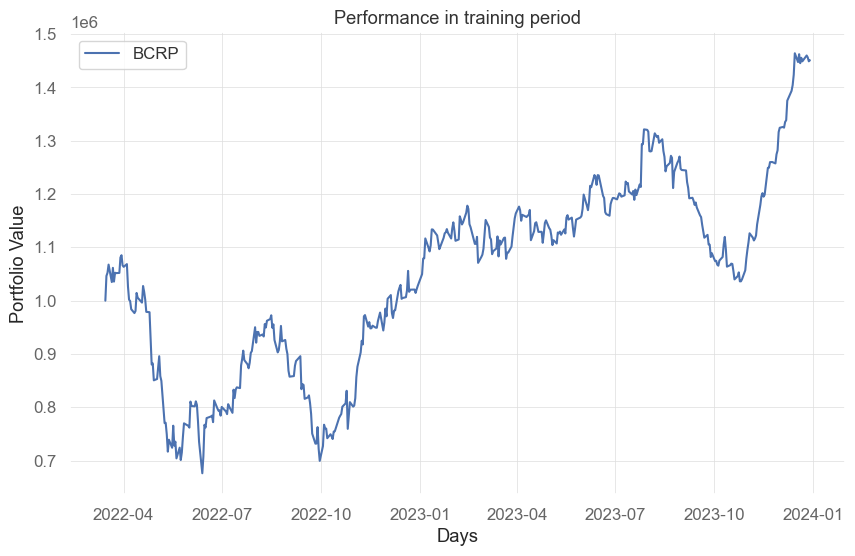

In [155]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(BCRP_results["date"], BCRP_results["training"], label="BCRP")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()